# Object Detection Demo: Safety Gear Detection


**!!!!!!!! UPDATE SECTION BELOW !!!!!!!!!!!**

This is a sample reference implementation to showcase object detection (safety gear in this case) with single-shot detection (SSD) and Async API.
Async API improves the overall frame-rate of the application by not waiting for the inference to complete but continuing to do things on the host while inference accelerator is busy. 
Specifically, this code demonstrates two parallel inference requests by processing the current frame while the next input frame is being captured. This essentially hides the latency of frame capture.

## Overview of how it works
At start-up the sample application reads the equivalent of command line arguments and loads a network and image from the video input to the Inference Engine (IE) plugin. 
A job is submitted to the hardware accelerator (Intel® Core CPU, Intel® HD Graphics GPU, Intel® Core CPU, Intel® Movidius™ and/or Neural Compute Stick)
After the inference is completed, the output videos are appropriately stored in the /results directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge hardware (rather than on the development node hosting this Jupyter notebook)
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes
* Demonstrate the Async API in action


## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell)

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))
from demoTools.demoutils import *

### 0.2  (Optional-step): Original video without inference

If you are curious to see the input video, run the following cell to view the orignal video stream used for inference and object detection.

In [2]:
!ln -sf safety-gear-resource-files/Safety_Full_Hat_and_Vest.mp4
videoHTML('Workers video', ['Safety_Full_Hat_and_Vest.mp4'])

## Step 1: Using OpenVINO

First, let's try running inference on a single image to see how OpenVINO works.
We will be using OpenVINO's Inference Engine (IE) to locate vehicles on the road.
There are five steps involved in this task:

1. Create a Intermediate Representation (IR) Model using the Intel Model Optimizer
2. Choose a device and create IEPlugin for the device
3. Read the IRModel using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Creating IR Model

Intel Model Optimizer creates Intermediate Representation (IR) models that are optimized for different end-point target devices.
These models can be created from existsing DNN models from popular frameworks (e.g. Caffe, TF) using the Intel Model Optimizer. 

Let's convert an existing Caffe model specially trained for detecting people, hardhats and safety vests using the model optimizer.

In [3]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo.py \
--input_model safety-gear-resource-files/worker_safety_mobilenet.caffemodel \
--model_name mobilenet-ssd \
--data_type FP32 \
-o models/mobilenet-ssd/FP32

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u19892/Downloads/FromGithub-intel-iot-devkit/iot-devcloud/python/safety-gear-detection-python/safety-gear-resource-files/worker_safety_mobilenet.caffemodel
	- Path for generated IR: 	/home/u19892/Downloads/FromGithub-intel-iot-devkit/iot-devcloud/python/safety-gear-detection-python/models/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Enable resnet optimizatio

**Note** the above line is a single command line input, which spans 4 lines thanks to the backslash '\\', which is a line continuation character in Bash.

Here, the arguments are:
* --input-model : the original model
* --data_type : Data type to use. One of {FP32, FP16, half, float}
* -o : outout dirctory

This script also supports `-h` that will you can get the full list of arguments.

With the `-o` option set as above, this command will write the output to the directory `models/mobilenet-ssd/FP32`

There are two files produced:
```
models/mobilenet-ssd/FP32/mobilenet-ssd.xml
models/mobilenet-ssd/FP32/mobilenet-ssd.bin
```
These will be used later in the exercise.

We will also be needing the FP16 version of the model for the calculations on the MYRIAD architecture. Run the following cell to create it.

In [4]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo.py \
--input_model safety-gear-resource-files/worker_safety_mobilenet.caffemodel \
--model_name mobilenet-ssd \
--data_type FP16 \
-o models/mobilenet-ssd/FP16 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u19892/Downloads/FromGithub-intel-iot-devkit/iot-devcloud/python/safety-gear-detection-python/safety-gear-resource-files/worker_safety_mobilenet.caffemodel
	- Path for generated IR: 	/home/u19892/Downloads/FromGithub-intel-iot-devkit/iot-devcloud/python/safety-gear-detection-python/models/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Enable resnet optimizatio

### 1.2 Choosing Device

Now we must select the device used for inferencing. This is done by loading the appropriate plugin to initialize the specified device and load the extensions library (if specified) provided in the extension/ folder for the device.


The following cell constructs **`IEPlugin`**:

In [6]:
from openvino.inference_engine import IEPlugin

def createPlugin(device, extension_list):
    # Plugin initialization for specified device. We will be targeting CPU initially.
    plugin = IEPlugin(device=device)

    # Loading additional exension libraries for the CPU
    for extension in extension_list:
        plugin.add_cpu_extension('/data/reference-sample-data/extension/libcpu_extension.so')
    
    return plugin

**Note**
Currently, three types of plugins are supported: CPU, GPU, and MYRIAD. CPU plugin may require additional extensions to improve performance, abd `add_cpu_extension` function is used to load these additional extensions.


### 1.3 Read the IR (Intermediate Representation) model

We can import optimized models (weights) from step 1.1 into our neural network using **`IENetwork`**. 


In [10]:
from openvino.inference_engine import IENetwork

def createNetwork(model_xml, model_bin, plugin):
    # Importing network weights from IR models.
    net = IENetwork.from_ir(model=model_xml, weights=model_bin)
    
    # Some layers in IR models may be unsupported by some plugins. 
    if "CPU" in plugin.device:
        supported_layers = plugin.get_supported_layers(net)
        not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
        if len(not_supported_layers) != 0:
            print("Following layers are not supported by the plugin for specified device {}:\n {}".
                      format(plugin.device, ', '.join(not_supported_layers)))
            print("Please try to specify cpu extensions library path in sample's command line parameters "
                  "using -l or --cpu_extension command line argument")
            return None
    return net

**Note**:
Some models may be incompatible with some target devices. For example, some types of neural network layers are not supported on the CPU target. 

### 1.4 Load the network into the plugin

Once we have the plugin and the network, we can load the network into the plugin using **`plugin.load`**.

In [9]:
def loadNetwork(plugin, net):
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=2)
    
    # Getting the input and outputs of the network
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    return exec_net,input_blob,out_blob


### 1.5 Run inference

Now we are ready to try running the inference workload using the plugin.
First let's load the image using OpenCV.
We will also have to do some shape manipulation to convert the image to a format that is compatible with our network


In [11]:
import cv2

def preprocessImage(img_path, net, input_blob):
    # Reading the frame from a jpeg file
    frame = cv2.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob].shape
    in_frame = cv2.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    return in_frame.reshape((n, c, h, w)),frame

For the inference, we will be running in **async_mode** by using `start_async` method. 
With the async_mode, the inference is started in parallel on either a separate thread or device.
In other words, `start_async` is non-blocking and the main process is free to do any additional processing needed. 
In the next section, we will see an implementation of pipelining to mask the latency of loading and modifying images.

During asynchronous runs, the different images are tracked by an integer `request_id`. 
Because we only have one image to process, we will just use 0.

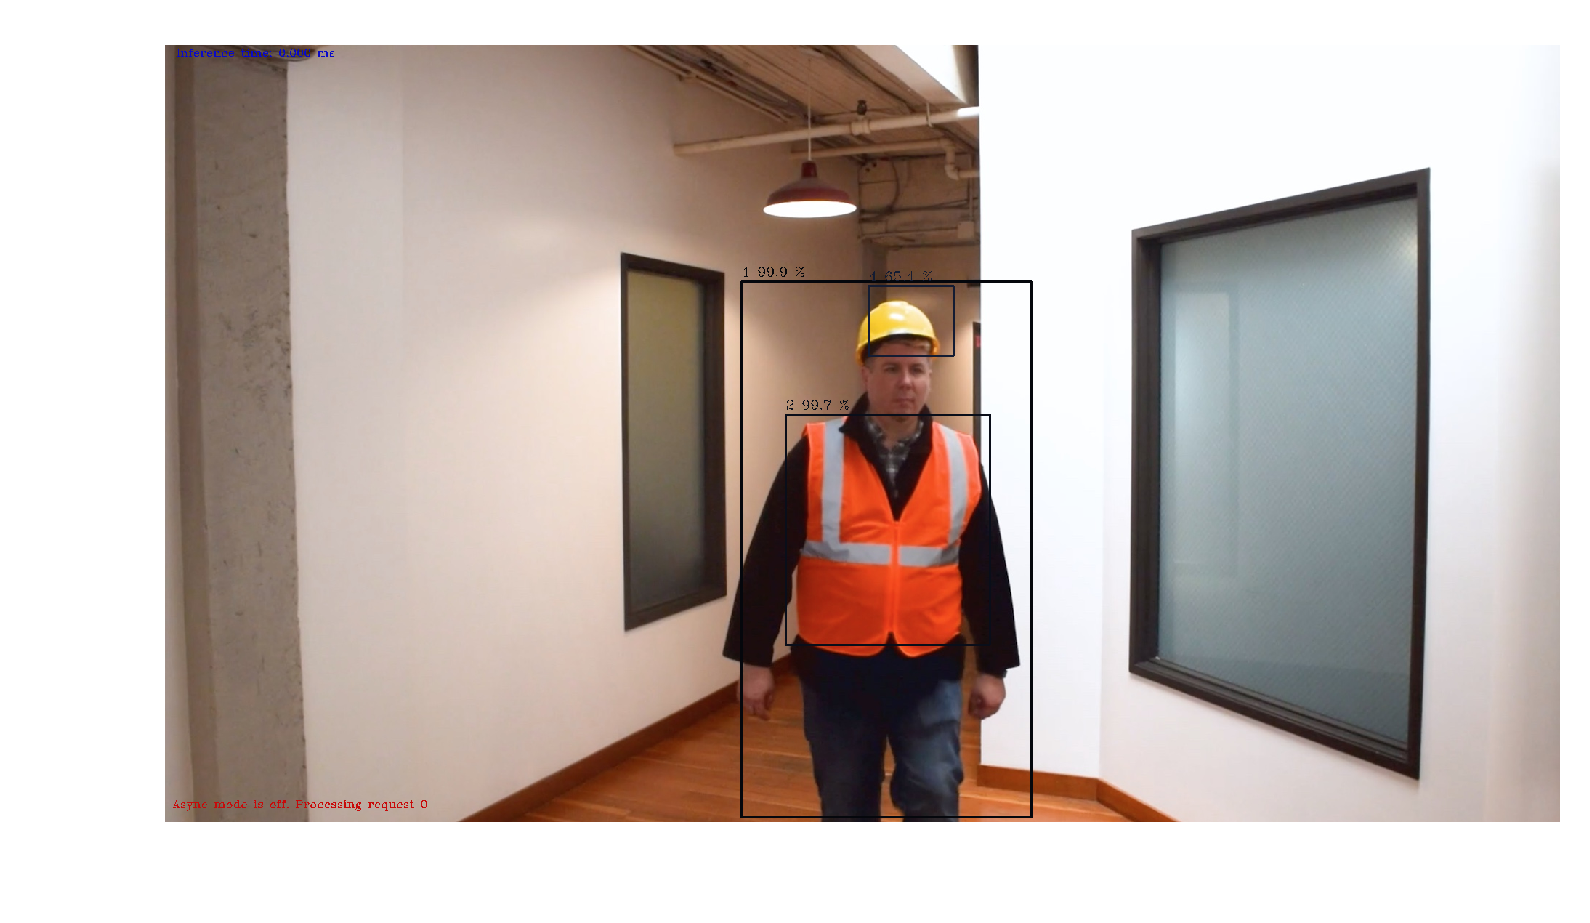

In [12]:
# For labeling the image
from out_process import placeBoxes


# Request id to keep track of
def runInference():
    plugin = createPlugin(device='CPU', extension_list=['/data/reference-sample-data/extension/libcpu_extension.so'])
    model_xml = "models/mobilenet-ssd/FP32/mobilenet-ssd.xml"
    model_bin = "models/mobilenet-ssd/FP32/mobilenet-ssd.bin"
    net = createNetwork(model_xml, model_bin, plugin)
    exec_net,input_blob,out_blob = loadNetwork(plugin, net)
    in_frame,original_frame = preprocessImage('safety-gear-resource-files/safety-gear-image.jpg', net, input_blob)
    
    my_request_id=0

    # Starting the inference in async mode, which starts the inference in parallel
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})
    # ... You can do additional processing or latency masking while we wait ...

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]

        # Processing the output result and adding labels on the image. Implementation is not shown in the
        #  this notebook; you can find it in object_detection_demo_ssd_async.py
        prob_threshold = 0.5  # 50% confidence needed for "detection"
        initial_w = original_frame.shape[1]
        initial_h = original_frame.shape[0]
        frame = placeBoxes(res, None, prob_threshold, original_frame, initial_w, initial_h, False, my_request_id, 0)
        # We use pyplot because it plays nicer with Jupyter Notebooks
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), interpolation='none')
        plt.axis("off")
        plt.show()
    else:
        print("There was an error with the request")
runInference()

## Step 2 : Inference on a video

Now that we know how to run inference on a single frame, let's extend this to multiple frames.
This part is already implemented in 
<a href="object_detection_demo_ssd_async.py">object_detection_demo_ssd_async.py</a>.
Most of the code is just an extension of the single frame example, but there are few points of importance that we highlight here.

The following lines determine the source of the video. We will use a pre-recorded input video file in this example, we could also use a camera by setting the input argument to 'cam'.
```python
if args.input == 'cam':
        input_stream = 0
        out_file_name = 'cam'
    else:
        input_stream = args.input
```
We capture frames from the video sample using **OpenCV VideoCapture** API.

```python
cap = cv2.VideoCapture(input_stream)
```

Finally, we have a latency masking scheme, where we post-process a frames while another frame is being processed on the inference engine.

```python
cur_request_id = 0
next_request_id = 1

while cap.isOpened():
   # ... load next frame from cap ...

   # start the next frame
   exec_net.start_async(request_id=next_request_id, inputs={input_blob: in_frame})

   # see if the current frame is ready
   if exec_net.requests[cur_request_id].wait(-1) == 0:
       # ... post-processing current frame ...
    
   # swap request ids
   cur_request_id, next_request_id = next_request_id, cur_request_id
```

The python code takes in command line arguments for video, model etc.

**Command line arguments options and how they are interpreted in the application source code**

```
SAMPLEPATH="/data/reference-sample-data"
python3 object_detection_demo_ssd_async.py -m models/mobilenet-ssd/$3/mobilenet-ssd.xml \
                                           -i safety-gear-resource-files/Safety_Full_Hat_and_Vest.mp4 \
                                           -o $1 \
                                           -d $2 \
                                           -l ${SAMPLEPATH}/extension/libcpu_extension.so
```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the **mobilenet-ssd** pre-trained model which has been pre-processed using the **model optimzer**
   There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
   (**Note** we are using mobilenet-ssd in this example. However, OpenVINO's Inference Engine is compatible with other neural network architectures such as AlexNet*, GoogleNet*, MxNet* etc.,)    

* -i location of the input video stream (safety-gear-resource-files/Safety_Full_Hat_and_Vest.mp4)
* -o location where the output file with inference needs to be stored. (results/core or results/xeon or results/gpu)
* -d Type of Hardware Acceleration (CPU or GPU or MYRIAD)
* -l Absolute path to the shared library and is currently optimized for core/xeon (extension/libcpu_extension.so )


### 2.1 Creating job file

All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel Xeon Scalable processor, where the Notebook is allocated a single core. 
To run inference on the entire video, we need more compute power.
We will run the workload on several edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "object_detection_job.sh"

In [12]:
%%writefile object_detection_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script

if [ "$2" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/intel/computer_vision_sdk/bin/setup_hddl.sh
    aocl program acl0 /opt/intel/computer_vision_sdk_2018.4.420/bitstreams/a10_vision_design_bitstreams/4-0_PL1_FP11_MobileNet_ResNet_VGG_Clamp.aocx
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 object_detection_demo_ssd_async.py -m /home/u19892/Downloads/FromGithub-intel-iot-devkit/iot-devcloud/python/safety-gear-detection-python/models/mobilenet-ssd/$3/mobilenet-ssd.xml \
                                           -i /home/u19892/Downloads/Jan31/safety-gear-resource-files/Safety_Full_Hat_and_Vest.mp4 \
                                           -o $1 \
                                           -d $2 \
                                           -l /data/reference-sample-data/extension/libcpu_extension.so \
                                           --labels /home/u19892/Downloads/Jan31/safety-gear-resource-files/labels.txt

g++ -std=c++14 ROI_writer.cpp -o ROI_writer  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/computer_vision_sdk/opencv/include/ -L/opt/intel/computer_vision_sdk/opencv/lib/

# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer "safety-gear-resource-files/Safety_Full_Hat_and_Vest.mp4" $1 $SKIPFRAME $RESOLUTION

Overwriting object_detection_job.sh




#### Setup the output video specs:


After running the object detection code, we have a list of bounding boxes for the detected objects. This may be the end of the object detection workflow some applications that just need the locations, sizes and types of the detected objects. However, if a human needs to view the output video stream, we may want to produce an output video where the bounding boxes are drawn on top of the detected objects.

We treat video rendering as a separate task, which is invoked by ROI_writer at the end of our job. If you don't want to spend a long time rendering the video, you can reduce the output video quality usinng the SKIP_FRAME and RESOLUTION variables:

* SKIP_FRAME=1 will write all processed video frames with bounding boxes into the output video (this is the slowest option and it preserves all inference data in the output video stream)
* SKIP_FRAME>1 will write only some of the processed frames into the output video (e.g., SKIP_FRAME=2 writes every other frame, SKIP_FRAME=10 writes one frame out of 10)
* RESOLUTION=1 will produce the output video with the same resolution as the input video (this is the slowest option)
* RESOLUTION<1 will reduce the output video desolution (e.g., RESOLUTION=0.5 will set the output video resolution in each dimension to 50% of the input video)

### 2.2 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit object_detection_job to 5 different types of edge compute nodes simultaneously or just one node at at time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets use name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass in arguments to the job script.
The [object_detection_job.sh](object_detection_job.sh) takes in 3 arguments:
1. the path to the directory for the output video and performance stats
2. targeted device (e.g. CPU,GPU,MYRIAD)
3. the floating precision to use for inference
The job scheduler will use the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [13]:
!pbsnodes | grep properties | sort | uniq -c

      2      properties = devnode,intel-xeon,gold6138,ram192gb,25gbe
     75      properties = iei-tank-core,compnode,intel-core,i5-6500TE,ram8gb,1gbe
      1      properties = iei-tank-core-myriadx,compnode,intel-core,i5-6500TE,ram8gb,1gbe
     11      properties = iei-tank-fpga,compnode,intel-core,i5-6500TE,ram8gb,1gbe
      4      properties = iei-tank-movidius,compnode,intel-core,i5-6500TE,ram8gb,1gbe
     14      properties = iei-tank-xeon,compnode,intel-xeon,E3-1268Lv5,ram32gb,1gbe
      1      properties = up2,compnode,intel-atom,ram8gb,1gbe


Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

### 2.3 Job queue submission

Each of the 4 cells below will submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all 5 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)



#### submitting to a node with Intel Core CPU

In [14]:
print("Submitting a job to an edge compute node with an Intel Core CPU...")
#Submit job to the queue
job_id_core = !qsub object_detection_job.sh -l nodes=1:iei-tank-core -F "results/core CPU FP32" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/core', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/core', 'v_progress_'+job_id_core[0]+'.txt', "Rendering", 0, 100)
else:
    print("Error in job submission.")

Submitting a job to an edge compute node with an Intel Core CPU...
4899.c003


#### submitting to a node with Intel Xeon CPU

In [15]:
print("Submitting a job to an edge compute node with an Intel Xeon CPU...")
#Submit job to the queue
job_id_xeon = !qsub object_detection_job.sh -l nodes=1:iei-tank-xeon -F "results/xeon CPU FP32" -N obj_det_xeon 
print(job_id_xeon[0]) 
#Progress indicators
if job_id_xeon:
    progressIndicator('results/xeon', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/xeon', 'v_progress_'+job_id_xeon[0]+'.txt', "Rendering", 0, 100)

Submitting a job to an edge compute node with an Intel Xeon CPU...
4900.c003


#### submitting to a node with Intel Core CPU and using the onboard Intel GPU

In [16]:
print("Submitting a job to an edge compute node with an Intel Core CPU and an Intel GPU...")
#Submit job to the queue
job_id_gpu = !qsub object_detection_job.sh -l nodes=1:iei-tank-core -F "results/gpu GPU FP32" -N obj_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/gpu', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/gpu', 'v_progress_'+job_id_gpu[0]+'.txt', "Rendering", 0, 100)

Submitting a job to an edge compute node with an Intel Core CPU and an Intel GPU...
4901.c003


#### submitting to a node with Intel Movidius NCS (Neural Computing Stick)

In [17]:
print("Submitting a job to an edge compute node with an Intel Movidius NCS...")
#Submit job to the queue
job_id_myriad = !qsub object_detection_job.sh -l nodes=1:iei-tank-movidius -F "results/myriad MYRIAD FP16" -N obj_det_myriad
print(job_id_myriad[0]) 
#Progress indicators
if job_id_myriad:
    progressIndicator('results/myriad', 'i_progress_'+job_id_myriad[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/myriad', 'v_progress_'+job_id_myriad[0]+'.txt', "Rendering", 0, 100)

Submitting a job to an edge compute node with an Intel Movidius NCS...
4902.c003


#### submitting to a node with Intel FPGA HDDL-F (High Density Deep Learning)

In [18]:
print("Submitting a job to an edge compute node with an Intel FPGA HDDL-F...")
#Submit job to the queue
job_id_fpga = !qsub object_detection_job.sh -l nodes=1:iei-tank-fpga -F "results/fpga HETERO:FPGA,CPU FP32" -N obj_det_fpga
print(job_id_fpga[0]) 
#Progress indicators
if job_id_fpga:
    progressIndicator('results/fpga', 'i_progress_'+job_id_fpga[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/fpga', 'v_progress_'+job_id_fpga[0]+'.txt', "Rendering", 0, 100)

Submitting a job to an edge compute node with an Intel FPGA HDDL-F...
4903.c003


### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up. 

In [19]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete. 

***Wait!***

Please wait for the inference jobs and video rendering complete before proceeding to the next step.

## Step 3: View Results

Once the jobs are completed, the queue system outputs the stdout and stderr streams of each job into files with names of the form

`obj_det_{type}.o{JobID}`

`obj_det_{type}.e{JobID}`

(here, obj_det_{type} corresponds to the `-N` option of qsub).

However, for this case, we may be more interested in the output video files. They are stored in mp4 format inside the `results/` directory.
We wrote a short utility script that will display these videos with in the notebook.
Run the cells below to display them.
See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook.


In [20]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/core/output_' + job_id_core[0] + '.mp4'], 
          'results/core/stats.txt')

In [21]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)',
          ['results/xeon/output_'+job_id_xeon[0]+'.mp4'],
          'results/xeon/stats.txt')

In [22]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/gpu/output_'+job_id_gpu[0]+'.mp4'],
          'results/gpu/stats.txt')

In [20]:
videoHTML('IEI Tank + Intel FPGA HDDL-F',
          ['results/fpga/output_'+job_id_fpga[0]+'.mp4'],
          'results/fpga/stats.txt')

In [21]:
videoHTML('IEI Tank + (Intel CPU + Movidius)',
          ['results/myriad/output_'+job_id_myriad[0]+'.mp4'],
          'results/myriad/stats.txt')

## Step 4: Assess Performance

The running time of each inference task is recorded in `results/*/stats.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

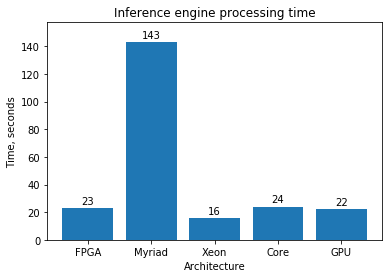

In [22]:
summaryPlot({'results/core/stats.txt':'Core', 'results/xeon/stats.txt':'Xeon', 'results/gpu/stats.txt':'GPU', 'results/fpga/stats.txt':'FPGA', 'results/myriad/stats.txt':'Myriad'}, 'Architecture', 'Time, seconds', 'Inference engine processing time' )